In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp -r /content/drive/MyDrive/Main_Data/Image/PPMI/* .

In [ ]:
!cat ppmi_brain.tar.gz.* | tar xzf -

In [ ]:
import nibabel as nib

In [ ]:
import numpy as np

def check_files(files):
  corrupted = []

  for file_path in files:

    try:
      # Load the NIfTI file
      nifti_img = nib.load(file_path)

      # Get the image data and header
      img_data = nifti_img.get_fdata()

      img_header = nifti_img.header

    except Exception as e:
      corrupted.append(e)

  return corrupted


In [ ]:
import glob

images = sorted(glob.glob('processed/**/*.nii.gz', recursive=True))

## Model

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F


class Auto3dCNN11(nn.Module):
    def __init__(self, input_size=(182, 182, 218)): #input: (182, 182, 218)
        super(Auto3dCNN11, self).__init__()

        output_size = list(input_size)
        self.sizes = [[18, 18, 22], [37, 37, 44]]

        self.encoder = nn.Sequential()
        self.decoder = nn.Sequential()

        # Encoder

        self.encoder.append(nn.Conv3d(1, 32, kernel_size=(5, 5, 5), stride=(5, 5, 5), padding=(2, 2, 2)))
        self.encoder.append(nn.ReLU())
        self.encoder.append(nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2)))
        self.encoder.append(nn.Conv3d(32, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1)))
        self.encoder.append(nn.ReLU())
        self.encoder.append(nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2)))
        self.encoder.append(nn.Conv3d(16, 8, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1)))
        self.encoder.append(nn.ReLU())

        # Decoder

        self.decoder.append(nn.ConvTranspose3d(8, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1)))
        self.decoder.append(nn.ReLU())
        self.decoder.append(nn.Upsample(size=self.sizes[0], mode='trilinear', align_corners=False))
        self.decoder.append(nn.ConvTranspose3d(16, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1)))
        self.decoder.append(nn.ReLU())
        self.decoder.append(nn.Upsample(size=self.sizes[1], mode='trilinear', align_corners=False))
        self.decoder.append(nn.ConvTranspose3d(32, 1, kernel_size=(5, 5, 5), stride=(5, 5, 5), padding=(2, 2, 2), output_padding=(1, 1, 2)))
        self.decoder.append(nn.Tanh())


    def forward(self, x):

        outputs = []
        for i, layer in enumerate(self.encoder):
          if i % 3 == 0: # convolution
            x = layer(x)
          elif i % 3 == 1: # activation
            x = layer(x)
            outputs.append(x)
          else: # upsample
            x = layer(x)

        out_i = len(outputs) - 1
        for i, layer in enumerate(self.decoder):
          if i % 3 == 0: # convolution
            x = x + outputs[out_i]
            x = layer(x)
            out_i -= 1
          elif i % 3 == 1: # activation
            x = layer(x)
          else: # upsample
            x = layer(x)
        return x

In [ ]:
from torchsummary import summary

In [ ]:
model = Auto3dCNN11()
summary(model, (1, 182, 182, 218), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv3d-1       [-1, 32, 37, 37, 44]           4,032
              ReLU-2       [-1, 32, 37, 37, 44]               0
         MaxPool3d-3       [-1, 32, 18, 18, 22]               0
            Conv3d-4       [-1, 16, 18, 18, 22]          13,840
              ReLU-5       [-1, 16, 18, 18, 22]               0
         MaxPool3d-6         [-1, 16, 9, 9, 11]               0
            Conv3d-7          [-1, 8, 9, 9, 11]           3,464
              ReLU-8          [-1, 8, 9, 9, 11]               0
   ConvTranspose3d-9         [-1, 16, 9, 9, 11]           3,472
             ReLU-10         [-1, 16, 9, 9, 11]               0
         Upsample-11       [-1, 16, 18, 18, 22]               0
  ConvTranspose3d-12       [-1, 32, 18, 18, 22]          13,856
             ReLU-13       [-1, 32, 18, 18, 22]               0
         Upsample-14       [-1, 32, 37,

## dataset creation

In [ ]:
from sklearn.model_selection import train_test_split

train_image_paths, valid_image_paths = train_test_split(images, test_size=0.10, random_state=22)


In [ ]:
import torch
from torch.utils.data import Dataset
from torchvision import transforms
import nibabel as nib
import numpy as np
from sklearn.preprocessing import LabelEncoder
import random
from torch.utils.data import WeightedRandomSampler, RandomSampler


class AEDatasetShifted(Dataset):

    def __init__(self, file_paths, transform=None):
        self.file_paths = file_paths
        self.transform = transform
        self.scale = scale

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        # idx = idx % len(self.file_paths)
        file_path = self.file_paths[idx]

        # Load NIfTI image
        nifti_img = nib.load(file_path)

        # Get the image data
        img_data = nifti_img.get_fdata()

        # Min max scale to (0, 1) range
        max_i = img_data.max()
        min_i = img_data.min()
        img_data = (img_data - min_i) / (max_i - min_i)

        # subsample by the factor of 4
        x_shift = random.randint(-1,1)
        y_shift = random.randint(-1,1)
        z_shift = random.randint(-1,1)
        img_data = np.roll(img_data, (x_shift, y_shift, z_shift), (0, 1, 2))

        # Expand dimensions to add a channel (assuming grayscale images)
        img_data = np.expand_dims(img_data, axis=0)

        # Permute dimensions to match [batch_size, channels, depth, height, width]
        # (42, 42, 50) -> (50, 42, 42)
        img_data = torch.FloatTensor(img_data).permute(0, 3, 1, 2)

        if self.transform:
            img_data = self.transform(img_data)

        return img_data


scale = 1

# Create the sampler
# unweighted
sampler = RandomSampler(range(len(train_image_paths)), replacement=False, num_samples=scale*len(train_image_paths))

# Create custom datasets
train_dataset = AEDatasetShifted(file_paths=train_image_paths)
valid_dataset = AEDatasetShifted(file_paths=valid_image_paths)

# Create data loaders
batch_size = 16
workers=8
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, sampler=sampler, num_workers=workers)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=workers)


## training

In [ ]:
import shutil
import os
from torch.utils.tensorboard import SummaryWriter

In [ ]:
def save_checkpoint(filename, epoch, model, optimizer, train_losses, test_losses, scheduler=None, early_stopper=None):

    save_path = '/content/drive/MyDrive/Main_Data/Checkpoints/part2' # outsource the timepoint

    if not os.path.isdir(save_path):
      os.makedirs(save_path)

    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'train_losses': train_losses,
        'test_losses': test_losses
    }

    if scheduler is not None:
        checkpoint['scheduler'] = scheduler.state_dict()

    if early_stopper is not None:
        checkpoint['early_stopper'] = early_stopper.state_dict()

    torch.save(checkpoint, filename)
    shutil.copyfile(filename, os.path.join(save_path, filename))

def load_checkpoint(filename, model, optimizer, scheduler=None, early_stopper=None):

    if not torch.cuda.is_available():
      checkpoint = torch.load(filename, map_location=torch.device('cpu'))
    else:
      checkpoint = torch.load(filename)

    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    train_losses = checkpoint['train_losses']
    test_losses = checkpoint['test_losses']

    if scheduler is not None:
        scheduler.load_state_dict(checkpoint['scheduler'])

    if early_stopper is not None:
        early_stopper.load_state_dict(checkpoint['early_stopper'])

    return epoch, train_losses, test_losses


In [ ]:
from typing import Dict, Any
from typing_extensions import TypeAlias
StateDict: TypeAlias = Dict[str, Any]

class StateDictAttributeError(AttributeError):

  def __init__(self, attribute_name):
    super().__init__(f"your state_dict lacks the parameter \"{attribute_name}\".")


class EarlyStopper:

    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

    def state_dict(self):
      return {"patience": self.patience, "min_delta": self.min_delta, "counter": self.counter, "min_validation_loss": self.min_validation_loss}

    def load_state_dict(self, state_dict: StateDict):

      if "patience" in state_dict:
        self.patience = state_dict["patience"]
      else:
        raise AttributeError("your state_dict lacks the parameter \"patience\".")

      if "min_delta" in state_dict:
        self.min_delta = state_dict["min_delta"]
      else:
        raise AttributeError("your state_dict lacks the parameter \"min_delta\".")

      if "counter" in state_dict:
        self.counter = state_dict["counter"]
      else:
        raise AttributeError("your state_dict lacks the parameter \"counter\".")

      if "min_validation_loss" in state_dict:
        self.min_validation_loss = state_dict["min_validation_loss"]
      else:
        raise AttributeError("your state_dict lacks the parameter \"min_validation_loss\".")


In [ ]:
params_filename = 'Auto3dCNN11_ppmi.pth'

In [ ]:
import torch
from tqdm.notebook import tqdm

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Instantiate the model
model = Auto3dCNN11()
model.to(device)

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=4e-4)
scheduler = optim.lr_scheduler.LinearLR(optimizer, start_factor=1.0, end_factor=0.5, total_iters=30)
early_stopper = EarlyStopper(patience=5, min_delta=0.0001)


s_epoch = -1

# Initialize the loss arrays
train_losses = []
valid_losses = []

# Load the training data if needed
if os.path.isfile(params_filename):
  s_epoch, train_losses, valid_losses = load_checkpoint(params_filename, model, optimizer, scheduler, early_stopper)

# Number of training epochs
num_epochs = 20

# Training loop
for epoch in range(s_epoch + 1, num_epochs):
    model.train()  # Set the model to training mode

    epoch_train_loss = 0

    print(f"Epoch {epoch}:")
    for batch_idx, data in enumerate(tqdm(train_loader)):
        data = data.to(device)
        optimizer.zero_grad()  # Zero the gradients

        # Forward pass
        output = model(data)

        # Calculate the loss
        loss = criterion(output, data)
        epoch_train_loss += loss.item()

        # Backward pass
        loss.backward()

        # Update weights
        optimizer.step()


    epoch_train_loss = epoch_train_loss / len(train_loader)

    # Validation loop
    model.eval()  # Set the model to evaluation mode

    epoch_valid_loss = 0

    with torch.no_grad():
        for batch_idx, data in enumerate(valid_loader):
            data = data.to(device)
            output = model(data)
            loss = criterion(output, data)
            epoch_valid_loss += loss.item()

    epoch_valid_loss = epoch_valid_loss / len(valid_loader)

    print(f'Validation Loss: {epoch_valid_loss:.4f}')
    print(f'Training Loss: {epoch_train_loss:.4f}')

    train_losses.append(epoch_train_loss)
    valid_losses.append(epoch_valid_loss)

    before_lr = optimizer.param_groups[0]["lr"]
    scheduler.step()
    after_lr = optimizer.param_groups[0]["lr"]
    print("Epoch %d: SGD lr %.6f -> %.6f" % (epoch, before_lr, after_lr))

    print(f'Epoch {epoch}: saving...')
    save_checkpoint(params_filename, epoch, model, optimizer, train_losses, valid_losses, scheduler=scheduler, early_stopper=early_stopper)

    # Check for early stopping possiblity
    if early_stopper.early_stop(epoch_valid_loss):
      print('Exitting this epoch early...')
      break



Epoch 0:


  0%|          | 0/105 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation Loss: 0.0029
Training Loss: 0.0201
Epoch 0: SGD lr 0.000400 -> 0.000393
Epoch 0: saving...
Epoch 1:


  0%|          | 0/105 [00:00<?, ?it/s]

Validation Loss: 0.0022
Training Loss: 0.0025
Epoch 1: SGD lr 0.000393 -> 0.000387
Epoch 1: saving...
Epoch 2:


  0%|          | 0/105 [00:00<?, ?it/s]

Validation Loss: 0.0017
Training Loss: 0.0020
Epoch 2: SGD lr 0.000387 -> 0.000380
Epoch 2: saving...
Epoch 3:


  0%|          | 0/105 [00:00<?, ?it/s]

Validation Loss: 0.0013
Training Loss: 0.0015
Epoch 3: SGD lr 0.000380 -> 0.000373
Epoch 3: saving...
Epoch 4:


  0%|          | 0/105 [00:00<?, ?it/s]

Validation Loss: 0.0010
Training Loss: 0.0011
Epoch 4: SGD lr 0.000373 -> 0.000367
Epoch 4: saving...
Epoch 5:


  0%|          | 0/105 [00:00<?, ?it/s]

Validation Loss: 0.0009
Training Loss: 0.0010
Epoch 5: SGD lr 0.000367 -> 0.000360
Epoch 5: saving...
Epoch 6:


  0%|          | 0/105 [00:00<?, ?it/s]

Validation Loss: 0.0009
Training Loss: 0.0009
Epoch 6: SGD lr 0.000360 -> 0.000353
Epoch 6: saving...
Epoch 7:


  0%|          | 0/105 [00:00<?, ?it/s]

Validation Loss: 0.0008
Training Loss: 0.0009
Epoch 7: SGD lr 0.000353 -> 0.000347
Epoch 7: saving...
Epoch 8:


  0%|          | 0/105 [00:00<?, ?it/s]

Validation Loss: 0.0008
Training Loss: 0.0008
Epoch 8: SGD lr 0.000347 -> 0.000340
Epoch 8: saving...
Epoch 9:


  0%|          | 0/105 [00:00<?, ?it/s]

Validation Loss: 0.0008
Training Loss: 0.0008
Epoch 9: SGD lr 0.000340 -> 0.000333
Epoch 9: saving...
Epoch 10:


  0%|          | 0/105 [00:00<?, ?it/s]

Validation Loss: 0.0008
Training Loss: 0.0008
Epoch 10: SGD lr 0.000333 -> 0.000327
Epoch 10: saving...
Epoch 11:


  0%|          | 0/105 [00:00<?, ?it/s]

Validation Loss: 0.0008
Training Loss: 0.0008
Epoch 11: SGD lr 0.000327 -> 0.000320
Epoch 11: saving...
Epoch 12:


  0%|          | 0/105 [00:00<?, ?it/s]

Validation Loss: 0.0008
Training Loss: 0.0008
Epoch 12: SGD lr 0.000320 -> 0.000313
Epoch 12: saving...
Epoch 13:


  0%|          | 0/105 [00:00<?, ?it/s]

Validation Loss: 0.0007
Training Loss: 0.0007
Epoch 13: SGD lr 0.000313 -> 0.000307
Epoch 13: saving...
Epoch 14:


  0%|          | 0/105 [00:00<?, ?it/s]

Validation Loss: 0.0007
Training Loss: 0.0007
Epoch 14: SGD lr 0.000307 -> 0.000300
Epoch 14: saving...
Epoch 15:


  0%|          | 0/105 [00:00<?, ?it/s]

Validation Loss: 0.0007
Training Loss: 0.0007
Epoch 15: SGD lr 0.000300 -> 0.000293
Epoch 15: saving...
Epoch 16:


  0%|          | 0/105 [00:00<?, ?it/s]

Validation Loss: 0.0007
Training Loss: 0.0007
Epoch 16: SGD lr 0.000293 -> 0.000287
Epoch 16: saving...
Epoch 17:


  0%|          | 0/105 [00:00<?, ?it/s]

Validation Loss: 0.0007
Training Loss: 0.0007
Epoch 17: SGD lr 0.000287 -> 0.000280
Epoch 17: saving...
Epoch 18:


  0%|          | 0/105 [00:00<?, ?it/s]

Validation Loss: 0.0007
Training Loss: 0.0007
Epoch 18: SGD lr 0.000280 -> 0.000273
Epoch 18: saving...
Epoch 19:


  0%|          | 0/105 [00:00<?, ?it/s]

Validation Loss: 0.0006
Training Loss: 0.0006
Epoch 19: SGD lr 0.000273 -> 0.000267
Epoch 19: saving...


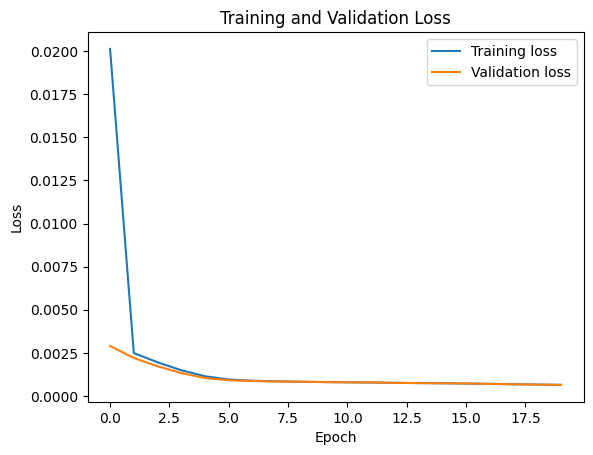

In [ ]:
import matplotlib.pyplot as plt

# Plot training and validation loss
plt.plot(train_losses, label='Training loss')
plt.plot(valid_losses, label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [ ]:
temp = model(valid_dataset[0][0].unsqueeze(0).unsqueeze(0).to(device))

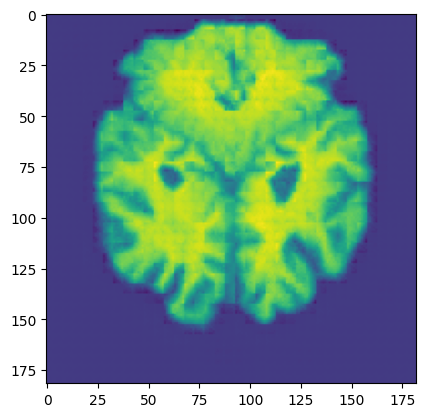

In [ ]:
plt.imshow(temp[0,0,:,:,75].detach().cpu())

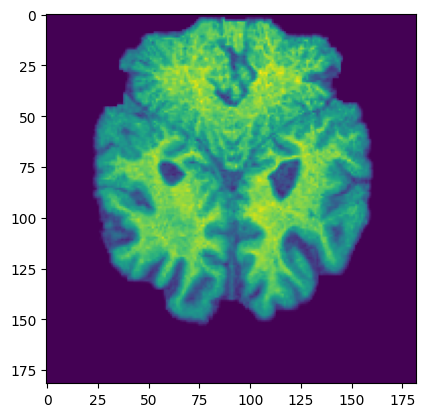

In [ ]:
plt.imshow(valid_dataset[0][0][:,:,75])